# JHU-CROWD++ preprocessing

In this notebook we prepare the data in JHU-CROWD++ dataset to evaluate the FamNet on it. The procedure is the same as in the CARPK notebook.

In [1]:
import numpy as np
import cv2
import os
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# We go to parent directory so we can import utils
os.chdir("./..")
from utils import matlab_style_gauss2D

RANDOM_SEED = 7
DATA_PATH = "data/JHU/jhu_crowd_v2.0/"

## Example

Here we first provide an example of a bounding box annotation and of our density map generation

### Bounding box

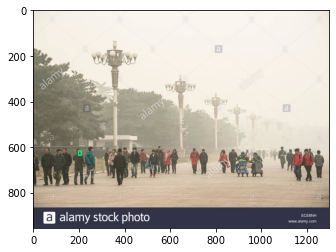

In [2]:
img = cv2.imread(DATA_PATH + "test/images/0002.jpg")
boxes = []
with open(DATA_PATH + "test/gt/0002.txt", "r") as f:
    for line in f:
        coords = line.split(" ")
        x1 = int(coords[0])
        y1 = int(coords[1])
        w = int(coords[2])
        h = int(coords[3])
        boxes.append([x1, y1, x1+w, y1+h])

first_box = boxes[0]
cv2.rectangle(img, (first_box[0], first_box[1]), (first_box[2], first_box[3]), (128, 255, 0), 4)
%matplotlib inline
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

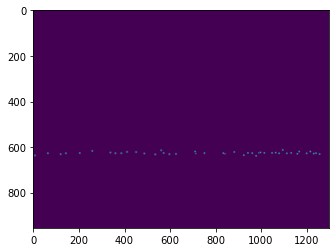

In [3]:
# Get image dimensions and create the density map of same size
h, w, _ = img.shape
density_map = np.zeros((h, w), dtype="float32")

# Add gaussian density for each bounding box
for box in boxes:
    # Get the dimension of bounding box
    w_box, h_box = box[2] - box[0], box[3] - box[1]
    # Get the gaussian density on that rectangle (as sigma we take 1/8 of the dimension average)
    density = matlab_style_gauss2D(shape=(h_box, w_box), sigma=(h_box + w_box) / 16)
    #print(density)
    # Add that density to density map
    density_map[box[1]:box[3], box[0]:box[2]] = density

plt.imshow(density_map)

## Estimate the number of exemplars distribution

In [4]:
# List of all images in FSC-147 dataset
im_list = os.listdir("data/images_384_VarV2")

# FSC-147 annotations
with open("data/annotation_FSC147_384.json") as f:
    annotations = json.load(f)

# Go through all images and get number of exemplars for each
n_exemplars = []
for img in im_list:
    annot = annotations[img]
    n_exemplars.append(len(annot["box_examples_coordinates"]))

# Get the density estimations
hist = np.histogram(n_exemplars, bins=np.arange(max(n_exemplars)+2), density=True)

print("Estimated probability distribution of number of exemplars for FSC-147 dataset (Number: probability)")
probs, numbers = hist
# Remove the last number as it was there just so the densities were calculated correctly
numbers = numbers[:-1]
for p, n in zip(probs, numbers):
    print(str(n)+":", p)

Estimated probability distribution of number of exemplars for FSC-147 dataset (Number: probability)
0: 0.0
1: 0.0
2: 0.0
3: 9.625772860397006e-01
4: 0.034493979824275954
5: 0.0027660266840221284
6: 0.00016270745200130165


## Create ground truths and exemplars, image resizing

In [5]:
# Function that takes dimensions and bounding boxes that represent cars and return the density map
def create_density_map(h, w, boxes):
    # Get image dimensions and create the density map of same size
    h, w, _ = img.shape
    density_map = np.zeros((h, w), dtype="float32")

    # Add gaussian density for each bounding box
    for box in boxes:
        # Get the dimension of bounding box
        w_box, h_box = box[2] - box[0], box[3] - box[1]
        # Get the gaussian density on that rectangle (as sigma we take 1/8 of the dimension average)
        density = matlab_style_gauss2D(shape=(h_box, w_box), sigma=(h_box + w_box) / 16)
        #print(density)
        # Add that density to density map
        density_map[box[1]:box[3], box[0]:box[2]] = density

    return density_map

# Function that takes .txt annotation file and return the bounding boxes for cars
def read_annotation(filename):
    boxes = []
    with open(filename, "r") as f:
        for line in f:
            coords = line.split(" ")
            x1 = int(coords[0])
            y1 = int(coords[1])
            w = int(coords[2])
            h = int(coords[3])
            boxes.append([x1, y1, x1+w, y1+h])

    return boxes

# Function that resize original bounding boxes to match the resized image
def resize_boxes(boxes, resize_ratio):
    resized_boxes = []
    for box in boxes:
        resized_boxes.append([int(round(value * resize_ratio)) for value in box])

    return resized_boxes

# Function that transforms bounding boxes given by two points into FSC-147 JSON format with 4 points
def to_json_boxes(boxes):
    transformed_boxes = []
    for box in boxes:
        transformed_boxes.append([[box[0], box[1]], [box[0], box[3]], [box[2], box[3]], [box[2], box[1]]])

    return transformed_boxes

# Function that returns the center points of given bounding boxes
def get_centers(boxes):
    return [[(box[0] + box[2]) / 2, (box[1] + box[3]) / 2] for box in boxes]

In [9]:
# Get the list of all images in CarPK dataset
img_list = os.listdir(DATA_PATH + "test/images")

# Dictionary for FSC-147 style annotations that will be created
transformed_annotations = {}

# Create the directory for transformed images if it does not exist already
if not os.path.exists(DATA_PATH + "Resized_images"):
    os.mkdir(DATA_PATH + "Resized_images")

# Set the random seed (for reproducibility)
np.random.seed(RANDOM_SEED)

for im_name in tqdm(img_list):
    # Annotation for this image that will be stored in JSON file
    new_annotation = {}

    # Read the image and get its dimensions
    img = cv2.imread(DATA_PATH + "test/images/" + im_name)
    h, w, _ = img.shape
    # Store the original dimensions in annotations as in the case of FSC-147 dataset
    new_annotation["H"] = h
    new_annotation["W"] = w

    # Get the bounding boxes
    boxes = read_annotation(DATA_PATH + "test/gt/" + im_name.rstrip("jpg") + "txt")

    # Resize the image to height 384
    resize_ratio = 384 / h
    new_h = 384
    new_w = int(round(w*resize_ratio))
    img = cv2.resize(img, dsize=(new_w, new_h))
    # Save the resized image
    cv2.imwrite(DATA_PATH + "Resized_images/" + im_name, img)
    # Store the resize ratio
    new_annotation["ratio_h"] = resize_ratio
    new_annotation["ratio_w"] = resize_ratio

    # Transform the bounding boxes for resized image
    boxes = resize_boxes(boxes, resize_ratio)

    # Select the exemplars
    n_exemplars = np.random.choice(numbers, p=probs)
    if len(boxes) <= n_exemplars:
        n_exemplars = len(boxes) // 2
    exemplar_idcs = np.random.choice(np.arange(len(boxes)), size=n_exemplars, replace=False)
    exemplars = [boxes[i] for i in exemplar_idcs]
    # Store the exemplars
    new_annotation["box_examples_coordinates"] = to_json_boxes(exemplars)

    # Get the center of each bounding box and store it as in the case of FSC-147 dataset
    dots = get_centers(boxes)
    # Store the centers
    new_annotation["points"] = dots

    transformed_annotations[im_name] = new_annotation

with open(DATA_PATH + "annotations_test.json", 'w') as f:
    json.dump(transformed_annotations, f, indent=4, sort_keys=True)

  0%|          | 0/1600 [00:00<?, ?it/s]

## Transform the data splits

In [ ]:
data_split = {}

for split in ["train", "test", "val"]:
    data_split[split] = list(os.listdir(DATA_PATH + split + "/images"))

with open(DATA_PATH + "train_test.json", 'w') as f:
    json.dump(data_split, f, indent=4, sort_keys=True)